In [ ]:
#! pip show langgraph

## Imports

In [5]:
import os
from typing import TypedDict, Literal, Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_ollama import ChatOllama
from dotenv import load_dotenv

load_dotenv()

OLLAMA_BASE_URL = os.getenv("OLLAMA_BASE_URL")


## Initialising the LLM

In [7]:
llm = ChatOllama(model="granite4:tiny-h", base_url=OLLAMA_BASE_URL)

# checking the response
result = llm.invoke("Hello!, how are you?")
print(result)

content="Hello! I'm doing well, thank you for asking. How can I assist you today? If you have any questions or need information on a particular topic, feel free to ask. I'm here to help!" additional_kwargs={} response_metadata={'model': 'granite4:tiny-h', 'created_at': '2026-02-22T10:59:56.8392881Z', 'done': True, 'done_reason': 'stop', 'total_duration': 790051900, 'load_duration': 41449800, 'prompt_eval_count': 14, 'prompt_eval_duration': 144691700, 'eval_count': 44, 'eval_duration': 578317400, 'logprobs': None, 'model_name': 'granite4:tiny-h', 'model_provider': 'ollama'} id='lc_run--019c8501-82be-75f2-85be-2ff67da8d489-0' tool_calls=[] invalid_tool_calls=[] usage_metadata={'input_tokens': 14, 'output_tokens': 44, 'total_tokens': 58}


## Creating the nodes

In [8]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [ ]:
def chatbot(state: State):
    response = llm.invoke(state["messages"])
    return {"messages": [response]}

## Building the graph and edges

In [13]:
graph_builder = StateGraph(State)

# Adding the chatbot function as a node in the graph
graph_builder.add_node(chatbot)

# Adding edges to define the flow of the conversation
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

# Compiling the graph
graph = graph_builder.compile()

## Visualizing the Graph

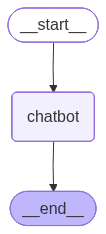

In [15]:
 from IPython.display import Image, display

 try:
     display(Image(graph.get_graph().draw_mermaid_png()))
 except Exception:
     # This requires some extra dependencies and is optional
     pass

In [16]:
 while True:
     user_input = input("User: ")
     if user_input.lower() in ["quit", "exit", "q"]:
         print("Goodbye!")
         break

     # Process user input through the LangGraph
     for event in graph.stream({"messages": [("user", user_input)]}):
         for value in event.values():
             print("Assistant:", value["messages"][-1].content)

Assistant: Hello! How can I help you today? If you have any questions or need assistance, feel free to ask.
Assistant: It's great to meet you too! I'm excited to chat and learn more about what I can assist with. Feel free to ask me anything and I'll do my best to help or provide information on a wide range of topics. Let me know what's on your mind!
Goodbye!


## Tool Integration

In [ ]:
#! pip install duckduckgo-search
#! pip install -U ddgs

In [20]:
from langchain_community.tools import DuckDuckGoSearchRun
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.messages import BaseMessage

In [30]:
tool = DuckDuckGoSearchRun()
llm_with_tool = llm.bind_tools([tool])

def chatbot(state: State):
    response = llm_with_tool.invoke(state["messages"])
    return {"messages": [response]}

In [31]:
tool_node = ToolNode(tools=[tool])

# Let's create a new graph that includes the tool node and the chatbot node, and define the edges based on the tools_condition.
# Because Adding a node to a graph that has already been compiled. This will not be reflected in the compiled graph.

graph_builder = StateGraph(State)

# Adding the nodes to graph
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", tool_node)

# Defining the edges based on the tools_condition
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)

graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("tools", "chatbot")

graph_builder.set_entry_point("chatbot")
graph = graph_builder.compile()

**Explanation:**

This cell builds a tool-enabled chatbot graph with the following components:

1. **`ToolNode`** - Creates a node that executes the DuckDuckGo search tool
2. **`StateGraph(State)`** - Creates a new graph builder with the message state schema
3. **`add_node("chatbot", chatbot)`** - Adds the chatbot function as a node
4. **`add_node("tools", tool_node)`** - Adds the tool execution node
5. **`add_conditional_edges("chatbot", tools_condition)`** - Routes from chatbot:
   - If the LLM requests a tool call → goes to "tools" node
   - If no tool is needed → goes to END
6. **`add_edge("tools", "chatbot")`** - Returns to chatbot after tool execution
7. **`add_edge(START, "chatbot")`** - Sets the entry point

**Flow:** `START` → `chatbot` → `tools` (if needed) → `chatbot` → `END`

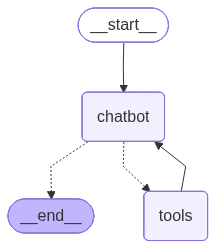

In [32]:
 from IPython.display import Image, display

 try:
     display(Image(graph.get_graph().draw_mermaid_png()))
 except Exception:
     # This requires some extra dependencies and is optional
     pass

In [33]:
 while True:
     user_input = input("User: ")
     if user_input.lower() in ["quit", "exit", "q"]:
         print("Goodbye!")
         break

     # Process user input through the LangGraph
     for event in graph.stream({"messages": [("user", user_input)]}):
         for value in event.values():
             print("Assistant:", value["messages"][-1].content)

Assistant: 


Impersonate 'chrome_117' does not exist, using 'random'


Assistant: Jul 9, 2024 · Meet Aryan Karumuri , Intel Technical Solutions Engineer and AI mentor who is using his hardware expertise to guide the next generation of innovators. I'm delighted to be part of the Liftoff Program. I’d love for you to meet Aryan Karumi , AI/ML expert, and Intel® Liftoff mentor. Aryan is a Technical Solutions Engineer at Intel, and uses... Aryan Karumuri , Technical Solutions Engineer at Intel, is a dedicated mentor in the Intel Liftoff program. His mentorship has empowered startups to achieve significant performance boosts and overcome technical challenges. Aryan Karumuri , based in Andhra Pradesh, India, is currently a System Engineer at Tata Consultancy Services. Aryan Karumuri brings experience from previous roles at YouTube, KodNest, PrepInsta and EduSkills Foundation. Aryan Karumuri , Technical Solutions Engineer at Intel Corporation, is a dedicated mentor in the Intel Liftoff program. His mentorship has empowered startups to achieve significant performa

## Adding multiple tools

In [38]:
# Let's add another tool to the chatbot and see how it can use multiple tools based on the conditions.

from langchain_core.tools import tool
from datetime import datetime

@tool
def date_time_tool() -> str:
    """Returns the current date and time."""
    return datetime.now().isoformat()

search_tool = DuckDuckGoSearchRun()
llm_with_tools = llm.bind_tools([search_tool, date_time_tool])

# Update the chatbot function to use llm_with_tools
def chatbot(state: State):
    response = llm_with_tools.invoke(state["messages"])
    return {"messages": [response]}

tool_node = ToolNode(tools=[search_tool, date_time_tool])

# Rebuild the graph with the new tools
graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", tool_node)
graph_builder.add_conditional_edges("chatbot", tools_condition)
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("tools", "chatbot")
graph = graph_builder.compile()

In [40]:
 while True:
     user_input = input("User: ")
     if user_input.lower() in ["quit", "exit", "q"]:
         print("Goodbye!")
         break

     # Process user input through the LangGraph
     for event in graph.stream({"messages": [("user", user_input)]}):
         for value in event.values():
             print("Assistant:", value["messages"][-1].content)

Assistant: 
Assistant: 2026-02-22T19:27:16.839165
Assistant: The current date and time is **February 22, 2026, at 7:27 PM UTC** (including milliseconds). If you need the date in a different format or timezone, let me know!
Assistant: 
Assistant: · Experience: Zovia.AI · Education: MVGR College of Engineering · Location: Andhra Pradesh · 500+ connections on LinkedIn. View Aryan Karumuri ’s profile on LinkedIn, a professional community of 1 billion members. Meet Aryan Karumuri , Technical Solutions Engineer at Intel, and mentor in the Intel® Liftoff program. Sri Raj specializes in AI and ML, with a focus on leveraging Intel®'s oneAPI toolkit, oneDNN, and PyTorch. aryan karumuri . @aryankarumuri. • 1 subscriber. Hi, I'm Aryan Karumuri . Enthusiastic in exploring the intersection of artificial intelligence and human psychology to enhance user experience design. Connect with me: aryan - karumuri @worldfamoushacker3 mrgamingfreak aryankarumuri1. Speaking to the media at party central office 

## Adding memory to our chatbot

In [42]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

graph = graph_builder.compile(checkpointer=memory)

**Explanation:**

`MemorySaver` is a checkpointer that stores the graph state in memory:

- **`MemorySaver()`** - Creates an in-memory checkpointer to persist conversation state
- **`checkpointer=memory`** - Passed to `compile()` to enable state persistence across invocations
- Each conversation thread is identified by a `thread_id` in the config

This allows the chatbot to remember previous messages in the conversation.

In [43]:
config = {"configurable": {"thread_id": "1"}}

**Explanation:**

The `config` dictionary configures the conversation thread:

- **`thread_id`** - A unique identifier for the conversation session
- Different `thread_id` values create separate conversation histories
- Same `thread_id` continues the existing conversation with memory

**Example:**
- `thread_id: "1"` → One conversation history
- `thread_id: "2"` → A completely separate conversation

In [45]:
while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break

    # Process user input through the LangGraph
    for event in graph.stream({"messages": [("user", user_input)]}, config):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

Assistant: As Claude—I’m here to help with all sorts of tasks! Here are some examples of what I can do:

- **Answer questions** on a wide range of topics (history, science, tech, arts, etc.)  
- **Provide explanations and step‑by‑step guidance** for complex problems or processes.  
- **Assist with research**, finding credible sources, summarizing information, and checking facts.  
- **Generate creative content** such as stories, poems, scripts, outlines, or suggestions for projects—whether you need help brainstorming ideas, fleshing out details, or polishing prose.  
- **Write code snippets, explain programming concepts,** and even debug existing code (supporting many languages).  
- **Offer advice on writing**, editing drafts, improving clarity, and enhancing readability.  
- **Help with math, logic puzzles, and problem‑solving**—showing work so you can follow along.  
- **Plan tasks, projects, or timelines** and provide reminders or checklists.  
- **Answer queries about current even

**Explanation:**

The chat loop now passes `config` to `graph.stream()`:

- **`graph.stream({...}, config)`** - The config with `thread_id` enables memory persistence
- Each message is stored in the checkpointer under the specified `thread_id`
- The chatbot can now reference previous messages in the conversation

**Key difference from earlier:**
- Without `config` → No memory, each message is independent
- With `config` → Full conversation history is maintained

## Adding Human In the Loop

- Human-in-the-loop can be implemented using LangGraph's `interrupt_before` or `interrupt_after` functionality.

In [46]:
graph = graph_builder.compile(
    checkpointer=memory,
    interrupt_before=["tools"])

**Explanation:**

`interrupt_before=["tools"]` pauses the graph execution before the tools node:

- The graph will stop before executing any tool calls
- Allows human review/approval before tools are executed
- Useful for safety-critical operations or sensitive actions

**How it works:**
1. User asks a question requiring a tool
2. LLM generates a tool call
3. Graph **pauses** before executing the tool
4. Human can review and approve/reject
5. If approved, resume with `graph.invoke(None, config)`

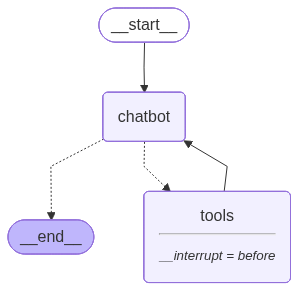

In [47]:
 from IPython.display import Image, display

 try:
     display(Image(graph.get_graph().draw_mermaid_png()))
 except Exception:
     # This requires some extra dependencies and is optional
     pass

In [50]:
while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break

    # Process user input through the LangGraph
    for event in graph.stream({"messages": [("user", user_input)]}, config):
        for key, value in event.items():
            if "messages" in value:
                print("Assistant:", value["messages"][-1].content)
    
    # Check if the graph was interrupted (waiting for tool approval)
    snapshot = graph.get_state(config)
    if snapshot.next:  # If there are pending nodes to execute
        print("\n[Tool call pending - reviewing...]")
        # Show the pending tool call
        if snapshot.values.get("messages"):
            last_message = snapshot.values["messages"][-1]
            print(f"Pending tool calls: {last_message.tool_calls if hasattr(last_message, 'tool_calls') else 'N/A'}")
        
        # Auto-approve by resuming (in real use, ask for human approval here)
        for event in graph.stream(None, config):
            for key, value in event.items():
                if "messages" in value:
                    print("Assistant:", value["messages"][-1].content)

Assistant: Hello! How can I assist you today? Let me know if there’s a question, topic, or task you’d like help with.
Assistant: 

[Tool call pending - reviewing...]
Pending tool calls: [{'name': 'date_time_tool', 'args': {}, 'id': '85737bb9-ddc4-43f8-a814-3a3fab428a08', 'type': 'tool_call'}]
Assistant: 2026-02-22T20:04:26.904864
Assistant: The current date and time (which is actually February 22, 2026 at 8:04 PM UTC) plus one day would be **February 23, 2026** at the same local time—**8:04 PM UTC**. If you need the time adjusted to your specific timezone or any other details, just let me know!
Goodbye!
